## Imports

In [4]:
from __future__ import division, print_function, absolute_import
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from math import ceil
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import pickle 
import scipy.ndimage
from PIL import Image as PILImage

## Mount drive if necessary

In [5]:
# from google.colab import drive
# drive.mount('gdrive/')
# os.chdir('gdrive/My Drive/Colab Notebooks/FACT/')
# '/gdrive/My Drive/Colab Notebooks/NLP1/Practical 2/googlenews.word2vec.300d.txt'

## Helper functions
Helper functions borrowed from original paper by Li et al. 

In [6]:
def makedirs(path):
    '''
    if path does not exist in the file system, create it
    '''
    if not os.path.exists(path):
        os.makedirs(path)

def list_of_norms(X):
    '''
    X is a list of vectors X = [x_1, ..., x_n], we return
        [d(x_1, x_1), d(x_2, x_2), ... , d(x_n, x_n)], where the distance
    function is the squared euclidean distance.
    '''
    return torch.sum(torch.pow(X, 2), dim=1)

def print_and_write(str, file):
    '''
    print str to the console and also write it to file
    '''
    print(str)
    file.write(str + '\n')

In [7]:
os.getcwd()

'/Users/TomLotze/Documents/Artificial Intelligence/Year 1/FACT/FACT/Reproduction'

## Create necessary folders

In [8]:
# data folder
makedirs('./data/mnist_color28')

# Models folder
model_folder = os.path.join(os.getcwd(), "saved_model", "mnist_model_color28")
makedirs(model_folder)

# Image folder
img_folder = os.path.join(model_folder, "img")
makedirs(img_folder)

# Model filename
model_filename = "mnist_cae_color28"

In [14]:
# # Transforms to perform on loaded dataset. Normalize around mean 0.1307 and std 0.3081 for optimal pytorch results. 
# # source: https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/4
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,),(0.3081,))])

# Load datasets into reproduction/data/mnist. Download if data not present. 
mnist_train = DataLoader(torchvision.datasets.MNIST('./data/mnist', train=True, download=True, transform=transforms))

mnist_train_data = mnist_train.dataset.data
mnist_train_targets = mnist_train.dataset.targets

# first 55000 examples for training
x_train = mnist_train_data[0:55000]
y_train = mnist_train_targets[0:55000]

# 5000 examples for validation set
x_valid = mnist_train_data[55000:60000]
y_valid = mnist_train_targets[55000:60000]

# 10000 examples in test set
mnist_test = DataLoader(torchvision.datasets.MNIST('./data/mnist', train=False, download=True, 
                                                   transform=transforms))

x_test = mnist_test.dataset.data
y_test = mnist_test.dataset.targets

train_data = TensorDataset(x_train, y_train)
valid_data = TensorDataset(x_valid, y_valid)
test_data = TensorDataset(x_test, y_test)


0.1%

100.1%

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz


28.4%

113.5%

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz


100.4%

Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz


180.4%

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [26]:
def color_dataset(raw_data):
    N = len(raw_data)
    raw_data = raw_data.view(N, 28, 28, 1)
    
    # Extend to RGB
    data_rgb = np.concatenate([raw_data, raw_data, raw_data], axis=3)
    
    # Make binary
    data_binary = (data_rgb > 0.5)
    data_color = np.zeros((N, 28, 28, 3))
    
    for i in range(N):
        # Take a random crop of the Lena image (background)
        x_c = np.random.randint(0, lena.size[0] - 28)
        y_c = np.random.randint(0, lena.size[1] - 28)
        image = lena.crop((x_c, y_c, x_c + 28, y_c + 28))
        image = np.asarray(image) / 255.0
        
        # Change color distribution
        for j in range(3):
            image[:, :, j] = (image[:, :, j] + np.random.uniform(0, 1)) / 2.0

        # Invert the colors at the location of the number
        image[data_binary[i]] = 1 - image[data_binary[i]]
        data_color[i] = image

    return torch.from_numpy(data_color)


## Add background to dataset

In [27]:
lena = PILImage.open('./resources/lena.png')

x_train_color = color_dataset(mnist_train_data)
x_test_color = color_dataset(x_test)

print(x_train_color.shape)
print(x_test_color.shape)

torch.Size([60000, 28, 28, 3])
torch.Size([10000, 28, 28, 3])


In [28]:
train_data_color = TensorDataset(x_train_color, mnist_train_targets)
test_data_color = TensorDataset(x_test_color, y_test)

## Save dataset

In [29]:
with open("./data/mnist_color28/MNIST_color28_train.p", "wb") as f:
    pickle.dump(train_data_color, f)
    
with open("./data/mnist_color28/MNIST_color28_test.p", "wb") as f:
    pickle.dump(test_data_color, f)

## Load the dataset

In [30]:
with open("./data/mnist_color28/MNIST_color28_train.p", "rb") as f:
    mnist_train = pickle.load(f)

with open("./data/mnist_color28/MNIST_color28_test.p", "rb") as f:
    mnist_test = pickle.load(f)
    
# first 55000 examples for training
x_train = mnist_train[0:55000][0]
y_train = mnist_train[0:55000][1]
# y_train = mnist_train_targets[0:55000]

# 5000 examples for validation set
x_valid = mnist_train[55000:60000][0]
y_valid = mnist_train[55000:60000][1]

# 10000 examples in test set
x_test = mnist_test[:][0]
y_test = mnist_test[:][1]

train_data = TensorDataset(x_train, y_train)
valid_data = TensorDataset(x_valid, y_valid)
test_data = TensorDataset(x_test, y_test)

## Parameters

In [37]:
# COPIED FROM THE ORIGINAL IMPLEMENTATION
# training parameters
learning_rate = 0.002
training_epochs = 1500

# frequency of testing and saving
test_display_step = 5    # how many epochs we do evaluate on the test set once, default 100
save_step = 50            # how frequently do we save the model to disk

# elastic deformation parameters
sigma = 4
alpha = 20

# lambda's are the ratios between the four error terms
lambda_class = 20
lambda_ae = 1 # autoencoder
lambda_1 = 1 # push prototype vectors to have meaningful decodings in pixel space
lambda_2 = 1 # cluster training examples around prototypes in latent space


input_height = input_width =  28    # MNIST data input shape 
n_input_channel = 3     # the number of color channels; for MNIST is 1.
input_size = input_height * input_width * n_input_channel   # 784
n_classes = 10

# Network Parameters
n_prototypes = 15         # the number of prototypes
n_layers = 4

# height and width of each layers' filters
f_1 = 3
f_2 = 3
f_3 = 3
f_4 = 3

# stride size in each direction for each of the layers
s_1 = 2
s_2 = 2
s_3 = 2
s_4 = 2

# number of feature maps in each layer
n_map_1 = 32
n_map_2 = 32
n_map_3 = 32
n_map_4 = 10

# the shapes of each layer's filter
# [out channel, in_channel, 3, 3]
filter_shape_1 = [n_map_1, n_input_channel, f_1, f_1]
filter_shape_2 = [n_map_2, n_map_1, f_2, f_2]
filter_shape_3 = [n_map_3, n_map_2, f_3, f_3]
filter_shape_4 = [n_map_4, n_map_3, f_4, f_4]

# strides for each layer (changed to tuples)
stride_1 = [s_1, s_1]
stride_2 = [s_2, s_2]
stride_3 = [s_3, s_3]
stride_4 = [s_4, s_4]


## Model construction
#### <font color='red'>Fix the stride and padding parameters, check if filter in tf is same as weight in pt</font>
Padding discussion pytorch: https://github.com/pytorch/pytorch/issues/3867

Blogpost: https://mmuratarat.github.io/2019-01-17/implementing-padding-schemes-of-tensorflow-in-python

In [45]:
class Encoder(nn.Module):
    '''Encoder'''
    def __init__(self):
        super(Encoder, self).__init__()
        
        # height and width of each layers' filters
        f_1 = 3
        f_2 = 3
        f_3 = 3
        f_4 = 3
        
        # define layers
        self.enc_l1 = nn.Conv2d(n_input_channel, 32, kernel_size=3, stride=2, padding=0)
        self.enc_l2 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=0)
        self.enc_l3 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=0)
        self.enc_l4 = nn.Conv2d(32, 10, kernel_size=3, stride=2, padding=0)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        
    def pad_image(self, img):
        ''' Takes an input image (batch) and pads according to Tensorflows SAME padding'''
        input_h = img.shape[2]
        input_w = img.shape[3]
        stride = 2 
        filter_h = 3
        filter_w = 3

        output_h = int(ceil(float(input_h)) / float(stride))
        output_w = output_h

        if input_h % stride == 0:
            pad_height = max((filter_h - stride), 0)
        else:
            pad_height = max((filter_h - (input_h % stride), 0))

        pad_width = pad_height

        pad_top = pad_height // 2
        pad_bottom = pad_height - pad_top
        pad_left = pad_width // 2
        pad_right = pad_width - pad_left

        padded_img = torch.zeros(img.shape[0], img.shape[1], input_h + pad_height, input_w + pad_width)
        padded_img[:,:, pad_top:-pad_bottom, pad_left:-pad_right] = img

        return padded_img
        
    def forward(self, x):
        pad_x = self.pad_image(x)
        el1 = self.relu(self.enc_l1(pad_x))
        
        pad_el1 = self.pad_image(el1)
        el2 = self.relu(self.enc_l2(pad_el1))
    
        pad_el2 = self.pad_image(el2)
        el3 = self.relu(self.enc_l3(pad_el2))
        
        pad_el3 = self.pad_image(el3)
        el4 = self.relu(self.enc_l4(pad_el3))
        
        return el4
        
class Decoder(nn.Module):
    '''Decoder'''
    def __init__(self):
        super(Decoder, self).__init__()
        # height and width of each layers' filters
        f_1 = 3
        f_2 = 3
        f_3 = 3
        f_4 = 3

        # define layers
        self.dec_l4 = nn.ConvTranspose2d(10, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_l3 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=0) # the output padding here should be 1 if the images are 32x32
        self.dec_l2 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_l1 = nn.ConvTranspose2d(32, n_input_channel, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, enc_x):
        dl4 = self.relu(self.dec_l4(enc_x))
        dl3 = self.relu(self.dec_l3(dl4))
        dl2 = self.relu(self.dec_l2(dl3))
        decoded_x = self.sigmoid(self.dec_l1(dl2))
        
        return decoded_x


class nn_prototype(nn.Module):
    '''Model'''
    def __init__(self, n_prototypes=15, n_layers=4, n_classes=10):
        super().__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        
        # initialize prototype - currently not in correct spot
        
        # changed this for the colored mnist, from 40 to 160, the new shape would be 250*10*4*4
        n_features = 40 # size of encoded x - 250 x 10 x 2 x 2
        self.prototype_feature_vectors = nn.Parameter(torch.empty(size=(n_prototypes, n_features), 
                                                                  dtype=torch.float32).uniform_())
        
        self.last_layer = nn.Linear(n_prototypes,10)
        
    def list_of_distances(self, X, Y):
        '''
        Given a list of vectors, X = [x_1, ..., x_n], and another list of vectors,
        Y = [y_1, ... , y_m], we return a list of vectors
                [[d(x_1, y_1), d(x_1, y_2), ... , d(x_1, y_m)],
                 ...
                 [d(x_n, y_1), d(x_n, y_2), ... , d(x_n, y_m)]],
        where the distance metric used is the sqared euclidean distance.
        The computation is achieved through a clever use of broadcasting.
        '''
        XX = torch.reshape(self.list_of_norms(X), shape=(-1, 1))
        YY = torch.reshape(self.list_of_norms(Y), shape=(1, -1))
        output = XX + YY - 2 * torch.mm(X, Y.t())

        return output

    def list_of_norms(self, X):
        '''
        X is a list of vectors X = [x_1, ..., x_n], we return
            [d(x_1, x_1), d(x_2, x_2), ... , d(x_n, x_n)], where the distance
        function is the squared euclidean distance.
        '''
        return torch.sum(torch.pow(X, 2), dim=1)
    
    def forward(self, x):
        
        #print("Shape of input x", x.shape)
        
        #encoder step
        enc_x = self.encoder(x)
        
        #print("Shape of encoded x", enc_x.shape)
        
        #decoder step
        dec_x = self.decoder(enc_x)
        
        #print("shape of decoded x", dec_x.shape)
        
        # hardcoded input size (not needed, shape already correct)
        # dec_x = dec_x.view(x.shape[0], x.shape[1], x.shape[2], x.shape[3])
        
        # flatten encoded x to compute distance with prototypes
        n_features = enc_x.shape[1] * enc_x.shape[2] * enc_x.shape[3]
        feature_vectors_flat = torch.reshape(enc_x, shape=[-1, n_features])
        
        #print("Shape of flattened feature vectors", feature_vectors_flat.shape)
        
        # distance to prototype
        prototype_distances = self.list_of_distances(feature_vectors_flat, self.prototype_feature_vectors)
        
        # distance to feature vectors
        feature_vector_distances = self.list_of_distances(self.prototype_feature_vectors, feature_vectors_flat)
        
        # classification layer
        logits = self.last_layer(prototype_distances)
        
        # Softmax to prob dist not needed as cross entropy loss is used?
        
        return dec_x, logits, feature_vector_distances, prototype_distances
        

## Cost function

In [51]:
'''
the error function consists of 4 terms, the autoencoder loss,
the classification loss, and the two requirements that every feature vector in
X look like at least one of the prototype feature vectors and every prototype
feature vector look like at least one of the feature vectors in X.
'''
def loss_function(X_decoded, X_true, logits, Y, feature_dist, prototype_dist, lambdas=None, print_flag=False):
    if lambdas == None:
        lam_class, lam_ae, lam_1, lam_2 = lambda_class, lambda_ae, lambda_1, lambda_2
    
    ae_error = torch.mean(list_of_norms(X_decoded - X_true))
#     ae_error = F.binary_cross_entropy(X_decoded, X_true)
    class_error = F.cross_entropy(logits, Y, reduction="mean")
    error_1 = torch.mean(torch.min(feature_dist, axis=1)[0])
    error_2 = torch.mean(torch.min(prototype_dist, axis = 1)[0])

    # total_error is the our minimization objective
    total_error = lam_class * class_error +\
                  lam_ae * ae_error + \
                  lam_1 * error_1 + \
                  lam_2 * error_2
    
    if print_flag == True:
        print('classification error', class_error.item())
        print('AE error: ', ae_error.item())
        print('Error 1 and 2', error_1.item(), error_2.item())
    return total_error

## Accuracy

In [52]:
def compute_acc(logits, labels):
    batch_size = labels.shape[0]
    predictions = logits.argmax(dim=1)
    total_correct = torch.sum(predictions == labels).item()
    accuracy = total_correct / batch_size
    
    return(accuracy)

## Training loop

In [53]:
def visualize_prototypes(model, epoch, save=True):
    # get saved prototypes
    encoded_prototypes = model.prototype_feature_vectors
    encoded_prototypes_reshaped = encoded_prototypes.view(n_prototypes, 10, 2, 2)

    # decode prototypes
    decoded_prototypes = model.decoder(encoded_prototypes_reshaped).detach().numpy()
    
    dec_prot = decoded_prototypes.transpose(0, 2, 3, 1)

    for i in range(n_prototypes):
        plt.imshow(dec_prot[i])
        if save:
            makedirs(img_folder+"/prototypes_epoch_"+ str(epoch))
            plt.savefig(img_folder+"/prototypes_epoch_"+ str(epoch)+"/"+str(i)+".png")
        else:
            plt.show()


Epoch: 0


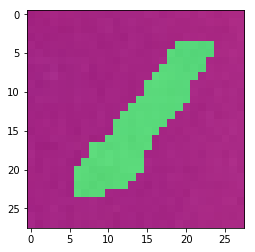

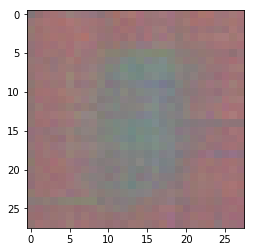

Last train loss of batch: 47.40250778198242
Train acc on batch: 0.12221004566210045
Last train acc 0.124


/Users/TomLotze/miniconda3/envs/fact/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type nn_prototype. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/TomLotze/miniconda3/envs/fact/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/TomLotze/miniconda3/envs/fact/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Model and prototypes of epoch 0 are saved

Test loss: 46.49867630004883
Test acc: 0.1713
classification error tensor(2.2295)
AE error:  tensor(0.0940)
Error 1 and 2 tensor(1.6122) tensor(0.2810)

Valid loss: 46.57788848876953
Valid acc: 0.173

Epoch: 1


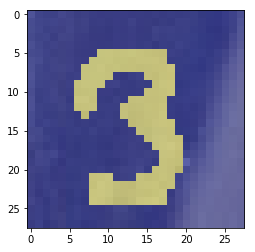

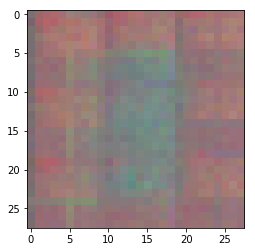

Last train loss of batch: 25.742877960205078
Train acc on batch: 0.465296803652968
Last train acc 0.66
classification error tensor(1.0375)
AE error:  tensor(0.0925)
Error 1 and 2 tensor(0.9889) tensor(2.4946)

Valid loss: 24.325456619262695
Valid acc: 0.6656

Epoch: 2


In [ ]:
model = nn_prototype(15,4,10)
batch_size_ = 250

# get validation and test set
valid_dl = DataLoader(valid_data, batch_size=5000, drop_last=False, shuffle=False)
test_dl = DataLoader(test_data, batch_size=10000, drop_last=False, shuffle=False)


# initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# initialize storage for results
train_accs = []
train_losses = []
test_accs = []
test_losses = []
valid_accs = []
valid_losses = []

# training loop
for epoch in range(training_epochs):
    print("\nEpoch:", epoch)

    # load the training data and reshuffle
    train_dl = DataLoader(train_data, batch_size=batch_size_, drop_last=False, shuffle=True)

    # loop over the batches
    for step, (x, Y) in enumerate(train_dl):
        optimizer.zero_grad()
        
        x_plot = x[0].clone()
        
        x = x.view(x.shape[0], n_input_channel, x.shape[1], x.shape[2]).float()

        #Y = Y.long()
        
        # perform forward pass
        X_decoded, logits, feature_dist, prot_dist = model(x)

        # compute the loss
        total_loss = loss_function(X_decoded, x, logits, Y, feature_dist, prot_dist)

        # backpropagate over the loss
        total_loss.backward()

        # update the weights
        optimizer.step()

        # compute and save accuracy and loss
        train_accuracy = compute_acc(logits, Y)
        train_accs.append(train_accuracy)
        train_losses.append(total_loss.item())
    
    # encode one training example to check:
    plt.imshow(x_plot)
    plt.show()
    plt.imshow(X_decoded[0].detach().view(28, 28, 3))
    plt.show()

    # print information after a batch
    print('Last train loss of batch:', total_loss.item())
    print('Train acc on batch:', np.mean(train_accs[-step:]))
    print("Last train acc", train_accuracy)


    if epoch % test_display_step == 0:
        # save model and prototypes
        torch.save(model, model_folder + "/" + model_filename + "_epoch_" + str(epoch) + '.pt')
  
        
        # save model prototypes
        visualize_prototypes(model, epoch, save = True)
        print("Model and prototypes of epoch %d are saved"%epoch)
        
        # perform testing
        with torch.no_grad():
            for (x_test, y_test) in test_dl:
                x_test = x_test.view(x_test.shape[0], n_input_channel, x_test.shape[1], x_test.shape[2]).float()

                #y_test = y_test.long()

                # forward pass
                X_decoded, logits, feature_dist, prot_dist = model(x_test)

                # compute loss and accuracy and save
                test_accuracy = compute_acc(logits, y_test)
                test_loss = loss_function(X_decoded, x_test, logits, y_test, feature_dist, prot_dist)
                test_accs.append(test_accuracy)
                test_losses.append(test_loss)

            print('\nTest loss:', test_loss.item())
            print('Test acc:', test_accuracy)

    # validation
    with torch.no_grad():
        for (x_valid, y_valid) in valid_dl:
                x_valid = x_valid.view(x_valid.shape[0], n_input_channel, x_valid.shape[1], x_valid.shape[2]).float()
        
                X_decoded, logits, feature_dist, prot_dist = model(x_valid)

                # compute losses and accuracy and save
                valid_accuracy = compute_acc(logits, y_valid)
                valid_loss = loss_function(X_decoded, x_valid, logits, y_valid, feature_dist, prot_dist, print_flag=True)
                valid_accs.append(valid_accuracy)
                valid_losses.append(valid_loss)

        print('\nValid loss:', valid_loss.item())
        print('Valid acc:', valid_accuracy)
    


## Loading the model and visualize prototypes

In [ ]:
# # load the model
# loaded_model = torch.load(model_folder+"/"+model_filename)

# with torch.no_grad():
#         for step, (x_valid, y_valid) in enumerate(valid_dl):
#                 x_valid = x_valid.view(x_valid.shape[0], 1, x_valid.shape[1], x_valid.shape[2]).float()
#                 X_decoded, logits, feature_dist, prot_dist = loaded_model(x_valid)

#                 # Check is model is indeed trained
#                 valid_accuracy = compute_acc(logits, y_valid)
#                 valid_loss = loss_function(X_decoded, x_valid, logits, y_valid, feature_dist, prot_dist)

#         print('\nValid loss:', valid_loss.item())
#         print('Valid acc:', valid_accuracy)

# visualize_prototypes(loaded_model, 1, False)

In [ ]:
# visualize prototypes from current model (in memory, not the loaded one)
visualize_prototypes(model, 1, 0)

## Saving and plotting of losses and accuracies

---



In [0]:
with open(model_folder + '/train_accs.p', 'wb') as f:
    pickle.dump(train_accs, f)

with open(model_folder + '/test_accs.p', 'wb') as f:
    pickle.dump(test_accs, f)

with open(model_folder + '/valid_accs.p', 'wb') as f:
    pickle.dump(valid_accs, f)

with open(model_folder + '/train_losses.p', 'wb') as f:
    pickle.dump(train_losses, f)

with open(model_folder + '/test_losses.p', 'wb') as f:
    pickle.dump(test_losses, f)

with open(model_folder + '/valid_losses.p', 'wb') as f:
    pickle.dump(valid_losses, f)

In [ ]:
v_t_epochs = list(range(0,len(train_accs)))
test_epochs = list(range(0,len(train_accs),test_display_step))
print(len(train_accs))
plt.figure(figsize=(15,12))
plt.plot(v_t_epochs, train_accs, label="Training accuracy")
plt.plot(v_t_epochs, valid_accs, label="Valid accuracy")
plt.plot(test_epochs, test_accs, label="Test accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(15,12))
plt.plot(v_t_epochs, valid_losses, label="Valid loss")
plt.plot(v_t_epochs, train_losses, label="Training loss")
plt.plot(test_epochs, test_losses, label="Test loss")
plt.legend()
plt.show()